In [57]:
import sys
if 'init_modules' in globals().keys():
    # second or subsequent run: remove all but initially loaded modules
    for m in sys.modules.keys():
        if m not in init_modules:
            del(sys.modules[m])
else:
    # first run: find out which modules were initially loaded
    init_modules = sys.modules.keys()
import numpy as np
from scipy import signal
from scipy import interpolate
import matplotlib.pyplot as plt 
import seaborn as sns
import cmocean
import os
import pyfilaments.analysisutils as analysis
from pyfilaments._def_analysis import *
import pandas as pd
import h5py

from joblib import Parallel, delayed
import multiprocessing
%matplotlib notebook
plt.close('all')

from tqdm import tqdm

save_folder = '/home/deepak/Dropbox/LacryModeling/processed_data/SearchDynamics'

## Load data

In [67]:
data_folder = '/home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/Analysis_test'

sim_folders = os.listdir(data_folder)

print(sim_folders)

['SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.59_activityTime_750_simType_point', 'SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.526_activityTime_750_simType_point', 'SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_0.821_activityTime_750_simType_point', 'SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point']


## Load the unique locations time-series data and assemble a dataframe

In [99]:
# Find all unique position time-series data 
n_time = 1000 # Number of time-points to interpolate the common time array

save_data = True
overwrite = True

save_file = os.path.join(save_folder, 'UniqueLocsVisited_FullData_test.csv')

if not os.path.exists(save_file) or overwrite==True:

    df_ensemble = pd.DataFrame({})  # Holds the data over all simulations

    for folder in sim_folders:
        # each sim_folder corresponds to a unique parameter set

        curr_folder = os.path.join(data_folder, folder)

        min_common_time = np.nan
        max_common_time = 0

        file_counter = 0

        time_array = {}
        unique_locs_array = {}
        analysis_file_array = {}

        sim_files = [file for file in os.listdir(curr_folder) if file.endswith('.hdf5')]

        for file in sim_files:

            # each .hdf5 file corresponds to a simulation run

            file_name = file[:-5]
            analysis_file = os.path.join('Analysis',file_name + '_analysis.csv')



            unique_pos_file = os.path.join('Analysis', 'SearchCoverage',file_name + '_unique_counts_timeseries.csv' )

            df_analysis = pd.read_csv(os.path.join(curr_folder, analysis_file))

            sim_complete = df_analysis['simulation completed'][0]

            if sim_complete:

                df_unique_pos = pd.read_csv(os.path.join(curr_folder, unique_pos_file))

                time = df_unique_pos['Time']

                min_common_time = min(np.max(time), min_common_time)

                max_common_time = max(np.min(time), max_common_time)

                time_array[file_counter] = time
                unique_locs_array[file_counter] = df_unique_pos['Unique positions count']

                analysis_file_array[file_counter] = analysis_file

                file_counter+=1


        if file_counter > 0:                
            # Create a common time-array

            print(file_counter)
            common_time_array = np.linspace(max_common_time, min_common_time, n_time)
            for ii in range(file_counter):

                time = time_array[ii]
                unique_locs = unique_locs_array[ii]

                analysis_file = analysis_file_array[ii]
                df_analysis = pd.read_csv(os.path.join(curr_folder, analysis_file))
                
                L = (df_analysis['N particles']-1)*df_analysis['bond length']
                theoretical_max_locs = int((L)**2)

                data_func = interpolate.interp1d(time, unique_locs, kind = 'linear')

                # Interpolate the data to a common time array
                unique_locs_sampled = data_func(common_time_array)
                

                # Save the interpolated data as well as other filament parameters in a new dataframe
                unique_locs_dict = {'Time':common_time_array, 'Initial condition': np.repeat(ii, n_times),
                                   'Unique positions count': unique_locs_sampled, 
                                    'Theoretical max locs':np.repeat(theoretical_max_locs, n_times)}
                
                filament_params_dict = {column:np.repeat(df_analysis[column][0], n_times) for column in df_analysis.columns}

                df_sampled = pd.DataFrame({**unique_locs_dict, **filament_params_dict})


                # Add this to the master data frame
                df_ensemble = pd.concat([df_ensemble, df_sampled], ignore_index=True)
    
    # 
    df_ensemble['Percent of max locs'] = 100*df_ensemble['Unique positions count']/df_ensemble['Theoretical max locs']
    
    if save_data:
        df_ensemble.to_csv(save_file)


else:
    print('Loading data from file ...')
    df_ensemble = pd.read_csv(save_file)


            

10
10
10
1


In [100]:
df_ensemble.tail()

print(np.unique(df_ensemble['activity number']))

[ 44.15671795  82.10389744  85.55364103 147.64902564]


<IPython.core.display.Javascript object>


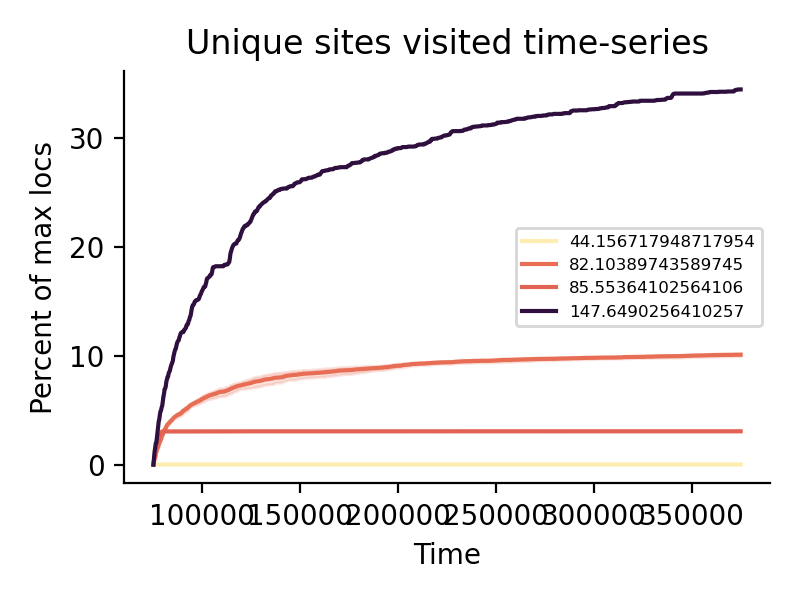

In [76]:
# Plot the unique locs sampled vs parameter

parameter = 'activity number'
y_data = 'Percent of max locs'
save = False

title = 'Unique sites visited time-series'
plt.figure(figsize=(4,3))

sns.lineplot(data = df_ensemble, x = 'Time', 
             y = y_data, hue = parameter, ci = 95, 
             palette = cmocean.cm.matter, legend = 'full')


plt.title(title)
plt.xlabel('Time')
# plt.yscale('log')
plt.legend(loc='best', prop={'size':6})
sns.despine(right=True, top=True)

plt.tight_layout()

if save:
    plt.savefig(os.path.join(publication_figures, title + '.png'), dpi = 300)
    plt.savefig(os.path.join(publication_figures, title + '.svg'), dpi = 300)

plt.show()

## For each parameter, fit the data to a Kinetic equation and store the results of the fit

In [113]:
# Aggregate and store the mean and std across different ICs of the same parameters

groupby_params = ['activity number', 'potDipole strength', ' activity time scale','Time']

result = df_ensemble.groupby(groupby_params, as_index=False).agg({'Percent of max locs':['mean', 'std']})

print(result)

parameter = 'activity number'
parameter_values  = np.unique(result[parameter])

print(parameter_values)

     activity number potDipole strength  activity time scale           Time  \
                                                                              
0          44.156718           0.820513                  750   75000.000000   
1          44.156718           0.820513                  750   75300.300300   
2          44.156718           0.820513                  750   75600.600601   
3          44.156718           0.820513                  750   75900.900901   
4          44.156718           0.820513                  750   76201.201201   
...              ...                ...                  ...            ...   
3995      147.649026           2.743590                  750  373798.798799   
3996      147.649026           2.743590                  750  374099.099099   
3997      147.649026           2.743590                  750  374399.399399   
3998      147.649026           2.743590                  750  374699.699700   
3999      147.649026           2.743590             

### Function for fitting

In [102]:
# Define the type of function we want to fit
import wlsice.python.wlsice as wlsice
import scipy.optimize as optimize

def f(t, N_max, Tau):
    """ Michelis-Mentin type function
    
        y = t*N_max/(t + Tau)
        
        
    """
    return N_max*t / (t + Tau)

<IPython.core.display.Javascript object>


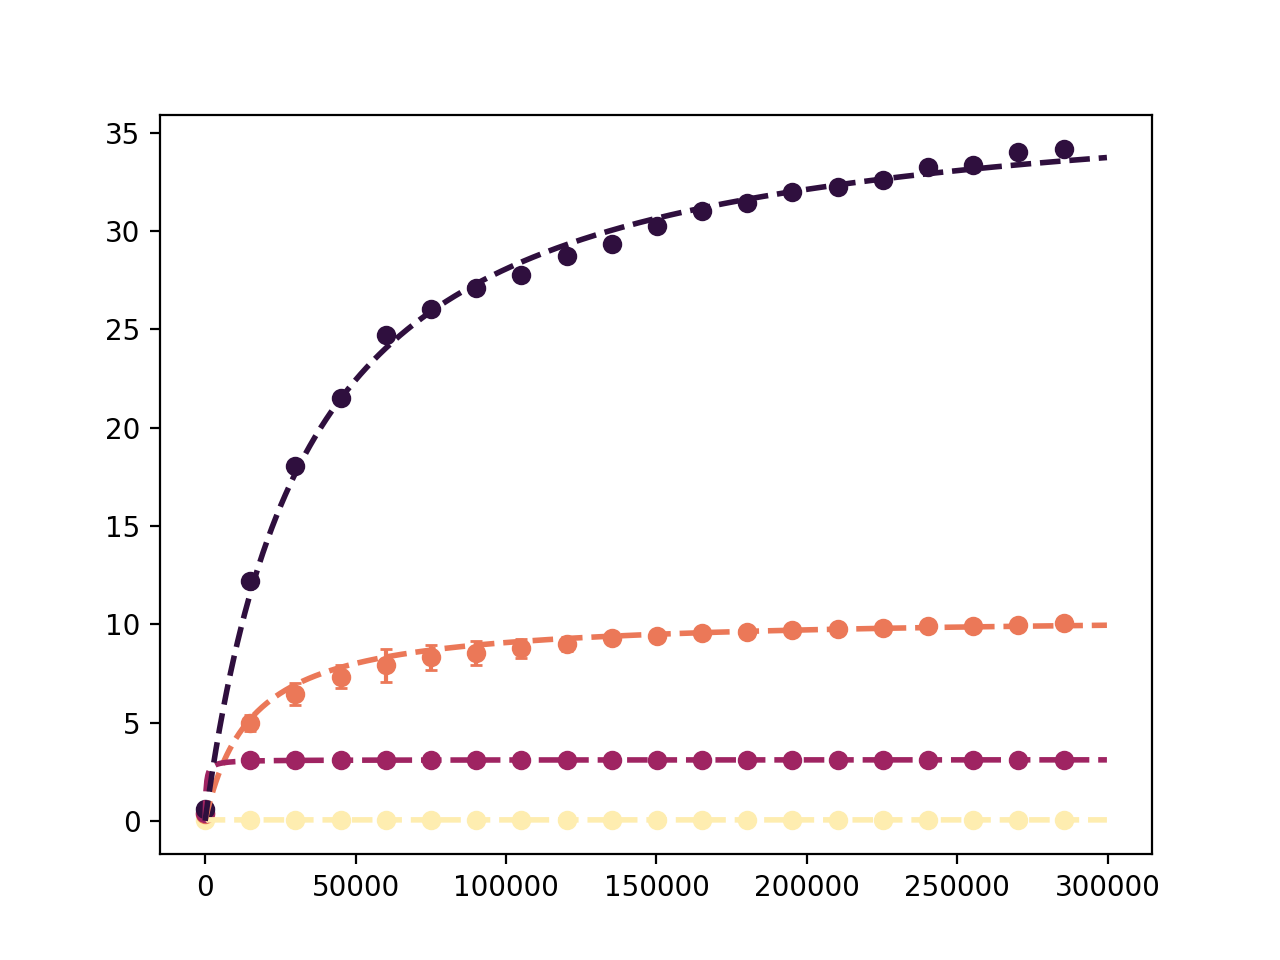

/home/deepak/anaconda3/envs/stokes_py3/lib/python3.6/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


In [120]:

df_unique_locs_fit = pd.DataFrame({})

cmap = cmocean.cm.matter
linear_array = np.linspace(0,1,len(parameter_values))
colors={}
for ii, cat in enumerate(parameter_values):
    
    colors[cat]=cmap(linear_array[ii])
    
plt.figure()
for value in parameter_values:
    
    df_chunk = result.loc[result[parameter]== value]
    
    time_array = np.array(df_chunk['Time'])
    
    # rescale the time array to start at 0
    time_array = time_array[1:]-time_array[1]
    
    unique_locs_means = np.array(df_chunk['Percent of max locs']['mean'][1:])
    unique_locs_std = np.array(df_chunk['Percent of max locs']['std'][1:])
    
    
    if np.any(np.isnan(unique_locs_std)) or np.any(unique_locs_std==0):
        
        p_opt, p_cov = optimize.curve_fit(f, time_array, unique_locs_means,
                       bounds = [(0, 0), (np.inf, np.inf)])
    else:
        p_opt, p_cov = optimize.curve_fit(f, time_array, unique_locs_means, sigma = unique_locs_std,
                   bounds = [(0, 0), (np.inf, np.inf)])
        
    perr = np.sqrt(np.diag(p_cov)) # Calculate error in the fit
    
    data_fit = np.array([f(time, p_opt[0], p_opt[1]) for time in time_array])
    
    plt.errorbar(time_array[::50], unique_locs_means[::50], yerr = unique_locs_std[::50], 
                 zorder = 0, linestyle = '', color = colors[value], capsize = 2, marker = 'o')
    
    plt.plot(time_array, data_fit, linestyle = '--', linewidth = 2, color = colors[value], label ='Fit', zorder = 1)
    
    
    unique_locs_fit_dict = {parameter:[value],
                         'Saturation value fit':[p_opt[0]], 'Saturation value sigma':[perr[0]], 
                            'Saturation time fit':[p_opt[1]], 'Saturation time sigma':[perr[1]]}
    
    filament_params_dict = {key: np.array(df_chunk[key])[0] for key in groupby_params}
    
    df_unique_locs_fit = df_unique_locs_fit.append(pd.DataFrame({**unique_locs_fit_dict, **filament_params_dict}))

plt.show()
    
    
    
    
    
 

In [121]:
df_unique_locs_fit

,activity number,Saturation value fit,Saturation value sigma,Saturation time fit,Saturation time sigma,potDipole strength,activity time scale,Time
0,44.156718,0.047193,0.000048,0.449854,7.564380,0.820513,750,75000.0
0,82.103897,10.459300,0.010316,15319.238918,140.188337,1.525641,750,75000.0
0,85.553641,3.104091,0.001884,311.432421,13.711872,1.589744,750,75000.0
0,147.649026,37.540993,0.045449,33696.516122,189.266032,2.743590,750,75000.0
